# 重回帰分析

説明変数（cpNum, cpNum_range, cpNum_dir, tree）と目的変数（バグ発見数）の重回帰分析を実行します。

まず、変数間の相関行列を確認し、多重共線性の問題がないかを検証します。


In [72]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (10, 6)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [73]:
# データ収集関数
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data(logs_root='Logs'):
    """
    全データを収集してDataFrameを作成
    各行（各実行）ごとに1つのデータポイントを作成
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            exe_time_path = param_dir / 'exe_time.csv'
            
            if not os.path.exists(detected_bugs_path) or not os.path.exists(exe_time_path):
                continue
            
            # まず、パラメータディレクトリ全体のバグ発見数をカウント
            total_bug_count = 0
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    if bug_row != ['null'] and bug_row != ['timeout']:
                        total_bug_count += 1
            
            # detected_bugs.csvとexe_time.csvの各行を読み込む（各実行ごとにデータポイントを作成）
            with open(detected_bugs_path, 'r') as bug_f, open(exe_time_path, 'r') as time_f:
                bug_reader = csv.reader(bug_f)
                time_reader = csv.reader(time_f)
                
                # 各行をペアで処理
                for bug_row, time_row in zip(bug_reader, time_reader):
                    # 実行時間を取得
                    try:
                        execution_time = int(time_row[0])
                    except (ValueError, IndexError):
                        continue
                    
                    # バグ発見数を判定（その行がバグかどうか）
                    is_bug = False
                    if bug_row != ['null'] and bug_row != ['timeout']:
                        is_bug = True
                    
                    # バグ発見までの時間を計算
                    # バグが発見された場合、その時点までの累積時間を記録
                    bug_time = None
                    if is_bug:
                        bug_time = execution_time
                    
                    # データポイントを作成
                    data_records.append({
                        'tree': tree_value,
                        'cpNum': cpnum,
                        'cpNum_range': cpnum_range,
                        'cpNum_dir': cpnum_dir,
                        'bug_count': total_bug_count,  # パラメータディレクトリ全体のバグ発見数
                        'bug_time': bug_time,  # バグ発見までの時間（バグが発見された場合のみ、各実行ごと）
                        'execution_time': execution_time  # その実行の実行時間（各実行ごと）
                    })
                    
                    # 累積時間を更新
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード（各行ごとに1つのデータポイント）")
    return df

# データ収集
df = collect_data()
print(f"\nデータの基本統計:")
print(df.describe())


データ収集完了: 10800件のレコード（各行ごとに1つのデータポイント）

データの基本統計:
               tree         cpNum   cpNum_range     cpNum_dir     bug_count  \
count  10800.000000  10800.000000  10800.000000  10800.000000  10800.000000   
mean     500.000000    225.000000     50.000000      1.150000      2.881019   
std      408.267192    234.016532     40.010185      0.572303      1.948549   
min        0.000000      1.000000      1.000000      1.000000      0.000000   
25%        0.000000     50.000000      1.000000      1.000000      1.000000   
50%      500.000000    149.500000     50.000000      1.000000      3.000000   
75%     1000.000000    300.000000     99.000000      1.000000      5.000000   
max     1000.000000    700.000000     99.000000      4.000000      5.000000   

            bug_time  execution_time  
count    6223.000000    10800.000000  
mean    23643.482886    28253.546389  
std     23903.914687    29980.425181  
min       966.000000      966.000000  
25%      5767.500000     7198.750000  
50%  

## 相関行列の確認

説明変数（cpNum, cpNum_range, cpNum_dir, tree）と目的変数（bug_count）の相関行列を可視化し、以下を確認します：

1. **説明変数間の相関**: 多重共線性（multicollinearity）の問題がないか確認
2. **説明変数と目的変数の相関**: 各説明変数がバグ発見数にどの程度影響しているか確認


相関行列（数値）
             cpNum  cpNum_range  cpNum_dir    tree  bug_count
cpNum        1.000       0.0000     0.0000 -0.0000     0.1890
cpNum_range  0.000       1.0000     0.0000 -0.0000     0.6641
cpNum_dir    0.000       0.0000     1.0000 -0.0000     0.0202
tree        -0.000      -0.0000    -0.0000  1.0000     0.0262
bug_count    0.189       0.6641     0.0202  0.0262     1.0000



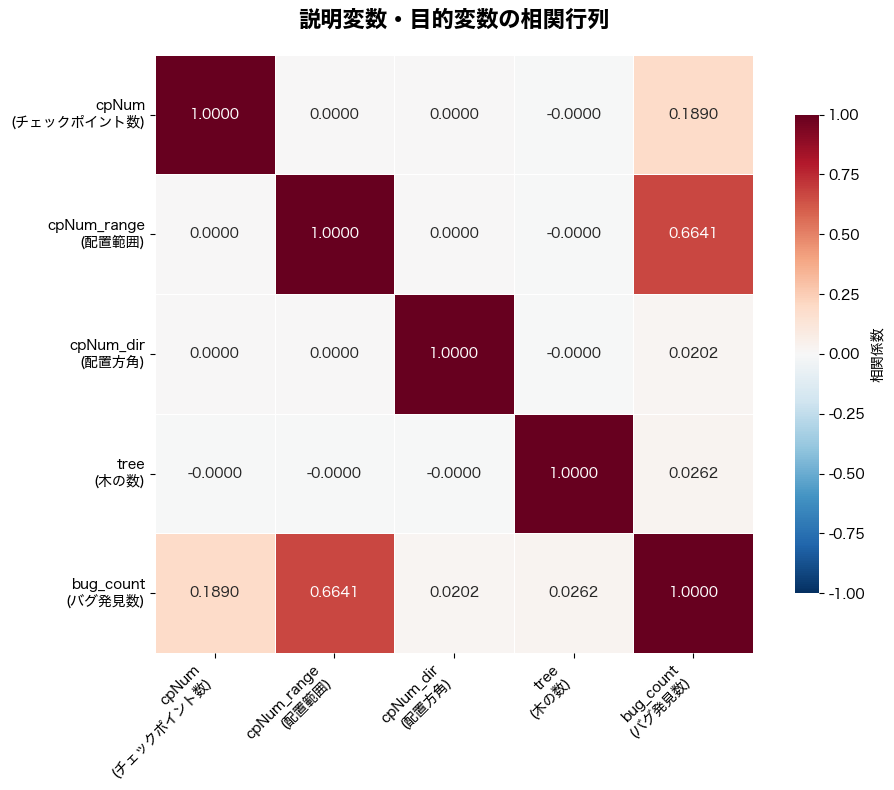


各説明変数とバグ発見数（bug_count）の相関係数
  cpNum: 0.1890 (正のほぼ無相関)
  cpNum_range: 0.6641 (正の中程度の相関)
  cpNum_dir: 0.0202 (正のほぼ無相関)
  tree: 0.0262 (正のほぼ無相関)


In [74]:
# 分析対象の変数を選択
variables = ['cpNum', 'cpNum_range', 'cpNum_dir', 'tree', 'bug_count']
df_analysis = df[variables]

# 相関行列の計算
correlation_matrix = df_analysis.corr()

print("="*60)
print("相関行列（数値）")
print("="*60)
print(correlation_matrix.round(4))
print()

# 相関行列のヒートマップを作成
fig, ax = plt.subplots(figsize=(10, 8))

# ヒートマップを描画
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt='.4f', 
    cmap='RdBu_r',  # 赤（正の相関）〜白（無相関）〜青（負の相関）
    center=0,
    vmin=-1, 
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': '相関係数', 'shrink': 0.8}
)

# タイトルと軸ラベルの設定
plt.title('説明変数・目的変数の相関行列', fontsize=16, fontweight='bold', pad=20)

# 軸ラベルを日本語に変換
labels = {
    'cpNum': 'cpNum\n(チェックポイント数)',
    'cpNum_range': 'cpNum_range\n(配置範囲)',
    'cpNum_dir': 'cpNum_dir\n(配置方角)',
    'tree': 'tree\n(木の数)',
    'bug_count': 'bug_count\n(バグ発見数)'
}
ax.set_xticklabels([labels.get(col, col) for col in correlation_matrix.columns], rotation=45, ha='right')
ax.set_yticklabels([labels.get(col, col) for col in correlation_matrix.index], rotation=0)

plt.tight_layout()
plt.show()

# 目的変数との相関係数を抽出して表示
print("\n" + "="*60)
print("各説明変数とバグ発見数（bug_count）の相関係数")
print("="*60)
target_correlations = correlation_matrix['bug_count'].drop('bug_count')
for var, corr in target_correlations.items():
    # 相関の強さを判定
    if abs(corr) >= 0.7:
        strength = "強い相関"
    elif abs(corr) >= 0.4:
        strength = "中程度の相関"
    elif abs(corr) >= 0.2:
        strength = "弱い相関"
    else:
        strength = "ほぼ無相関"
    
    direction = "正の" if corr > 0 else "負の"
    print(f"  {var}: {corr:.4f} ({direction}{strength})")


説明変数間の相関行列（多重共線性の確認）
             cpNum  cpNum_range  cpNum_dir  tree
cpNum          1.0          0.0        0.0  -0.0
cpNum_range    0.0          1.0        0.0  -0.0
cpNum_dir      0.0          0.0        1.0  -0.0
tree          -0.0         -0.0       -0.0   1.0



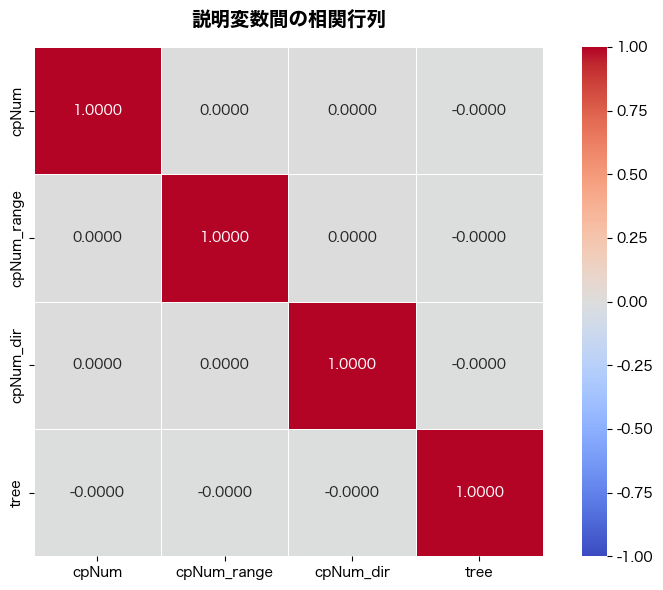


多重共線性の判定
説明変数間に高い相関（|r| >= 0.7）は見られません。
多重共線性の問題は低いと考えられます。


In [75]:
# 説明変数間の相関を詳しく確認（多重共線性のチェック）
explanatory_vars = ['cpNum', 'cpNum_range', 'cpNum_dir', 'tree']
exp_correlation = df[explanatory_vars].corr()

print("="*60)
print("説明変数間の相関行列（多重共線性の確認）")
print("="*60)
print(exp_correlation.round(4))
print()

# 説明変数間の相関ヒートマップ
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    exp_correlation, 
    annot=True, 
    fmt='.4f', 
    cmap='coolwarm',
    center=0,
    vmin=-1, 
    vmax=1,
    square=True,
    linewidths=0.5
)
plt.title('説明変数間の相関行列', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# 多重共線性の判定
print("\n" + "="*60)
print("多重共線性の判定")
print("="*60)
high_correlation_pairs = []
for i in range(len(explanatory_vars)):
    for j in range(i+1, len(explanatory_vars)):
        corr = exp_correlation.iloc[i, j]
        if abs(corr) >= 0.7:
            high_correlation_pairs.append((explanatory_vars[i], explanatory_vars[j], corr))

if high_correlation_pairs:
    print("警告: 以下の説明変数間に高い相関（|r| >= 0.7）が見られます：")
    for var1, var2, corr in high_correlation_pairs:
        print(f"  {var1} と {var2}: {corr:.4f}")
    print("\n多重共線性の問題がある可能性があります。VIFを確認してください。")
else:
    print("説明変数間に高い相関（|r| >= 0.7）は見られません。")
    print("多重共線性の問題は低いと考えられます。")


## バグ発見数の重回帰分析

In [ ]:
y = df['bug_count']
X = df[['cpNum', 'cpNum_range', 'cpNum_dir', 'tree']]
X_const = sm.add_constant(X)

# モデルの作成
model = sm.OLS(y, X_const)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              bug_count   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     2469.
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:31:02   Log-Likelihood:                -19020.
No. Observations:               10800   AIC:                         3.805e+04
Df Residuals:                   10795   BIC:                         3.809e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7684      0.041     18.875      

### F検定
- F値: 493.0
  - 大きめ？
- Prob (F-statistic): 4.64e-302
  - ほぼゼロ

### 自由度調整済み決定係数
- R-squared: 0.478
- Adj. R-squared: 0.477




# バグ発見までの時間との重回帰分析

In [77]:
y = df['bug_time']
X = df[['cpNum', 'cpNum_range', 'cpNum_dir', 'tree']]
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const, missing='drop')
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               bug_time   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     79.28
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           1.04e-65
Time:                        18:31:02   Log-Likelihood:                -71414.
No. Observations:                6223   AIC:                         1.428e+05
Df Residuals:                    6218   BIC:                         1.429e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.674e+04   1027.074     16.301      

# 実行時間との重回帰分析

In [78]:
y = df['execution_time']
X = df[['cpNum', 'cpNum_range', 'cpNum_dir', 'tree']]
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         execution_time   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     284.5
Date:                Wed, 26 Nov 2025   Prob (F-statistic):          6.38e-233
Time:                        18:31:02   Log-Likelihood:            -1.2611e+05
No. Observations:               10800   AIC:                         2.522e+05
Df Residuals:                   10795   BIC:                         2.523e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         2.09e+04    824.438     25.354      

## AICベースの変数増減法（Stepwise Selection）によるモデル最適化

変数増減法は、前向き選択法と後向き消去法を組み合わせた手法です。
- **前向き選択**: AICが改善する変数を追加
- **後向き消去**: AICが改善する変数を削除
- これを収束するまで繰り返す


In [1]:
def stepwise_selection_aic(data, target, features, verbose=True):
    """
    AICを基準とした変数増減法（Stepwise Selection）
    
    Args:
        data: DataFrame
        target: 目的変数の列名
        features: 説明変数の候補リスト
        verbose: 詳細出力の有無
    
    Returns:
        best_features: 最適な説明変数のリスト
        best_model: 最適なモデル
    """
    remaining_features = list(features)
    selected_features = []
    
    # 切片のみのモデルのAIC
    X_const = sm.add_constant(pd.DataFrame({'const': np.ones(len(data))}))
    base_model = sm.OLS(data[target], X_const).fit()
    current_aic = base_model.aic
    
    if verbose:
        print(f"初期AIC（切片のみ）: {current_aic:.2f}")
        print("="*60)
    
    improved = True
    step = 0
    
    while improved:
        improved = False
        step += 1
        
        # ===== 前向き選択（Forward Step）=====
        forward_candidates = []
        for feature in remaining_features:
            test_features = selected_features + [feature]
            X = sm.add_constant(data[test_features])
            model = sm.OLS(data[target], X).fit()
            forward_candidates.append((feature, model.aic, model))
        
        if forward_candidates:
            forward_candidates.sort(key=lambda x: x[1])
            best_forward = forward_candidates[0]
            
            if best_forward[1] < current_aic:
                selected_features.append(best_forward[0])
                remaining_features.remove(best_forward[0])
                current_aic = best_forward[1]
                improved = True
                
                if verbose:
                    print(f"Step {step}: + {best_forward[0]} を追加 → AIC = {current_aic:.2f}")
        
        # ===== 後向き消去（Backward Step）=====
        if len(selected_features) > 1:
            backward_candidates = []
            for feature in selected_features:
                test_features = [f for f in selected_features if f != feature]
                X = sm.add_constant(data[test_features])
                model = sm.OLS(data[target], X).fit()
                backward_candidates.append((feature, model.aic, model))
            
            backward_candidates.sort(key=lambda x: x[1])
            best_backward = backward_candidates[0]
            
            if best_backward[1] < current_aic:
                selected_features.remove(best_backward[0])
                remaining_features.append(best_backward[0])
                current_aic = best_backward[1]
                improved = True
                
                if verbose:
                    print(f"Step {step}: - {best_backward[0]} を削除 → AIC = {current_aic:.2f}")
    
    # 最終モデルの構築
    X = sm.add_constant(data[selected_features])
    best_model = sm.OLS(data[target], X).fit()
    
    if verbose:
        print("="*60)
        print(f"最終選択された変数: {selected_features}")
        print(f"最終AIC: {best_model.aic:.2f}")
    
    return selected_features, best_model

print("変数増減法の関数を定義しました")


変数増減法の関数を定義しました


In [80]:
# 説明変数の候補
features = ['cpNum', 'cpNum_range', 'cpNum_dir', 'tree']

# 1. バグ発見数（bug_count）に対する変数増減法
print("="*70)
print("【バグ発見数（bug_count）の変数選択】")
print("="*70)
print()
best_features_bug, best_model_bug = stepwise_selection_aic(df, 'bug_count', features)
print("\n")
print("最適モデルのサマリー")
print(best_model_bug.summary())


【バグ発見数（bug_count）の変数選択】

初期AIC（切片のみ）: 45059.11
Step 1: + cpNum_range を追加 → AIC = 38779.88
Step 2: + cpNum を追加 → AIC = 38068.52
Step 3: + tree を追加 → AIC = 38056.35
Step 4: + cpNum_dir を追加 → AIC = 38049.95
最終選択された変数: ['cpNum_range', 'cpNum', 'tree', 'cpNum_dir']
最終AIC: 38049.95


最適モデルのサマリー
                            OLS Regression Results                            
Dep. Variable:              bug_count   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     2469.
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:31:02   Log-Likelihood:                -19020.
No. Observations:               10800   AIC:                         3.805e+04
Df Residuals:                   10795   BIC:                         3.809e+04
Df Model:                           4                                         

In [81]:
# 2. バグ発見時間（bug_time）に対する変数増減法
# 欠損値を除外したデータを使用（インデックスをリセット）
df_bug_time = df.dropna(subset=['bug_time']).reset_index(drop=True)

print("="*70)
print("【バグ発見時間（bug_time）の変数選択】")
print("="*70)
print()
best_features_time, best_model_time = stepwise_selection_aic(df_bug_time, 'bug_time', features)
print("\n")
print("最適モデルのサマリー")
print(best_model_time.summary())


【バグ発見時間（bug_time）の変数選択】

初期AIC（切片のみ）: 143139.16
Step 1: + cpNum_range を追加 → AIC = 142902.24
Step 2: + tree を追加 → AIC = 142838.33
Step 3: + cpNum を追加 → AIC = 142836.39
最終選択された変数: ['cpNum_range', 'tree', 'cpNum']
最終AIC: 142836.39


最適モデルのサマリー
                            OLS Regression Results                            
Dep. Variable:               bug_time   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     105.5
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           1.37e-66
Time:                        18:31:02   Log-Likelihood:                -71414.
No. Observations:                6223   AIC:                         1.428e+05
Df Residuals:                    6219   BIC:                         1.429e+05
Df Model:                           3                                         
Covariance Type:            nonrobust           

In [82]:
# 3. 実行時間（execution_time）に対する変数増減法
print("="*70)
print("【実行時間（execution_time）の変数選択】")
print("="*70)
print()
best_features_exec, best_model_exec = stepwise_selection_aic(df, 'execution_time', features)
print("\n")
print("最適モデルのサマリー")
print(best_model_exec.summary())


【実行時間（execution_time）の変数選択】

初期AIC（切片のみ）: 253309.35
Step 1: + cpNum を追加 → AIC = 252511.96
Step 2: + cpNum_range を追加 → AIC = 252365.02
Step 3: + tree を追加 → AIC = 252234.65
最終選択された変数: ['cpNum', 'cpNum_range', 'tree']
最終AIC: 252234.65


最適モデルのサマリー
                            OLS Regression Results                            
Dep. Variable:         execution_time   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     378.7
Date:                Wed, 26 Nov 2025   Prob (F-statistic):          6.68e-234
Time:                        18:31:02   Log-Likelihood:            -1.2611e+05
No. Observations:               10800   AIC:                         2.522e+05
Df Residuals:                   10796   BIC:                         2.523e+05
Df Model:                           3                                         
Covariance Type:            nonrobust       

In [83]:
# 変数選択結果のサマリー
print("="*70)
print("変数増減法による変数選択結果サマリー")
print("="*70)
print()

summary_data = {
    '目的変数': ['bug_count', 'bug_time', 'execution_time'],
    '選択された変数': [
        ', '.join(best_features_bug),
        ', '.join(best_features_time),
        ', '.join(best_features_exec)
    ],
    'AIC': [
        f"{best_model_bug.aic:.2f}",
        f"{best_model_time.aic:.2f}",
        f"{best_model_exec.aic:.2f}"
    ],
    'Adj. R-squared': [
        f"{best_model_bug.rsquared_adj:.4f}",
        f"{best_model_time.rsquared_adj:.4f}",
        f"{best_model_exec.rsquared_adj:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print()
print("※ AICが低いほど良いモデル")
print("※ Adj. R-squaredは説明力（高いほど良い）")


変数増減法による変数選択結果サマリー

          目的変数                             選択された変数       AIC Adj. R-squared
     bug_count cpNum_range, cpNum, tree, cpNum_dir  38049.95         0.4776
      bug_time            cpNum_range, tree, cpNum 142836.39         0.0479
execution_time            cpNum, cpNum_range, tree 252234.65         0.0950

※ AICが低いほど良いモデル
※ Adj. R-squaredは説明力（高いほど良い）


In [84]:
# 全変数モデルとの比較
print("="*70)
print("全変数モデル vs 変数選択後モデル の比較")
print("="*70)
print()

# 全変数モデルを作成
X_full = sm.add_constant(df[features])
full_model_bug = sm.OLS(df['bug_count'], X_full).fit()
full_model_time = sm.OLS(df_bug_time['bug_time'], sm.add_constant(df_bug_time[features])).fit()
full_model_exec = sm.OLS(df['execution_time'], X_full).fit()

comparison_data = {
    '目的変数': ['bug_count', 'bug_count', 'bug_time', 'bug_time', 'execution_time', 'execution_time'],
    'モデル': ['全変数', '変数選択後', '全変数', '変数選択後', '全変数', '変数選択後'],
    '変数数': [4, len(best_features_bug), 4, len(best_features_time), 4, len(best_features_exec)],
    'AIC': [
        f"{full_model_bug.aic:.2f}",
        f"{best_model_bug.aic:.2f}",
        f"{full_model_time.aic:.2f}",
        f"{best_model_time.aic:.2f}",
        f"{full_model_exec.aic:.2f}",
        f"{best_model_exec.aic:.2f}"
    ],
    'Adj. R²': [
        f"{full_model_bug.rsquared_adj:.4f}",
        f"{best_model_bug.rsquared_adj:.4f}",
        f"{full_model_time.rsquared_adj:.4f}",
        f"{best_model_time.rsquared_adj:.4f}",
        f"{full_model_exec.rsquared_adj:.4f}",
        f"{best_model_exec.rsquared_adj:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print()
print("※ AICが減少していれば、変数選択によりモデルが改善された")


全変数モデル vs 変数選択後モデル の比較

          目的変数   モデル  変数数       AIC Adj. R²
     bug_count   全変数    4  38049.95  0.4776
     bug_count 変数選択後    4  38049.95  0.4776
      bug_time   全変数    4 142837.61  0.0479
      bug_time 変数選択後    3 142836.39  0.0479
execution_time   全変数    4 252235.06  0.0950
execution_time 変数選択後    3 252234.65  0.0950

※ AICが減少していれば、変数選択によりモデルが改善された
